Now that you have all these data, we can begin processing and combining them together

# Harmonizing GEDI and Sentinel Data
The way we do data harmonization is by selecting GEDI point that is __contained__ within a pixel

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('..')
from gedi_adb.dataset.gedi_processor import get_transect_profile
from gedi_adb.dataset.data_integrator import harmonize_data, harmonize_data_single, append_var_from_tif

# Part 1: Load Sentinel Data

In [4]:
sentinels_path = './data/training/sentinel' # DEFINE YOUR OWN PATH
sentinels = [os.path.join(sentinels_path, file) for file in os.listdir(sentinels_path) if file.endswith('.npy')]

print(f'There are {len(sentinels)} sentinel files')

There are 11 sentinel files


# Part 2: Load GEDI Data
(see notebook 1 for specific instructions on downloading)

NOTE: only for training data, NOT for validation sites

In [5]:
gedi_path = './data/training/gedi'
gedi_type = 'GEDI04_A' # Change this if you are using GEDI L4 data
gedis = [os.path.join(gedi_path, g) for g in os.listdir(gedi_path) if g.startswith(gedi_type)]

print(f'There are {len(gedis)} GEDI files')

There are 7 GEDI files


In [6]:
# Process the GEDI data to get the AGB/RHinformation
for file in tqdm(gedis):
    df = get_transect_profile(file, is_filter=True, var='agbd') # var is one of ['rh', 'agbd']
    try:
        gedi_df = pd.concat([gedi_df, df], axis=0, ignore_index=True)
    except:
        gedi_df = df

100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


In [7]:
gedi_df.head()

,lat,lon,time,z_ground,agbd
0,45.435397,-69.145890,2021-06-01 19:21:42.196858898,145.404282,170.152451
1,45.420961,-69.147114,2021-06-01 19:21:42.374534845,124.320145,133.164841
2,49.343037,-56.284163,2021-06-01 19:24:16.399259850,46.615234,34.810894
3,46.282987,-90.449975,2021-06-01 20:55:05.876225650,460.387604,107.174377
4,46.350071,-90.265127,2021-06-01 20:55:08.206784800,462.156097,222.871109


In [8]:
# You can save it as CSV for faster future usage
processed_gedi_path = os.path.join(gedi_path, 'processed_l4_gedi_test.csv')
gedi_df.to_csv(processed_gedi_path)

# Part 3: Load Climate Data

SIF: see `notebook/01c_get_climate_data` to retrieve and process the SIF data

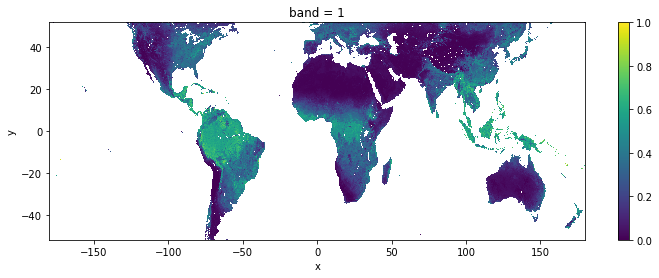

In [11]:
# Loading
sif_path = './data/training/sif/gosif_gpp/'
sif_df = xr.open_rasterio(os.path.join(sif_path, 'processed_sif.tif'))

sif_df.plot(figsize=(12,4))

# Part 4a: Data Integration - with GEDI
__OPTION A__: For training/non-ALS validation that requires only GEDI for RH/AGB

Now that we have all the necessary data, let's begin integrating them by first converting our GEDI DataFrame as GeoDataFrame

In [12]:
# For RH
processed_gedi_path = './data/training/gedi'

gedi_df = pd.read_csv(os.path.join(processed_gedi_path, 'processed_gedi.csv'))
gedi_df = gpd.GeoDataFrame(gedi_df, geometry=gpd.points_from_xy(x=gedi_df.lon, y=gedi_df.lat))

In [14]:
# For AGB
processed_gedi_path = './data/training/gedi'

gedi_df = pd.read_csv(os.path.join(processed_gedi_path, 'processed_l4_gedi_test.csv'))
gedi_df = gpd.GeoDataFrame(gedi_df, geometry=gpd.points_from_xy(x=gedi_df.lon, y=gedi_df.lat))

Finally, we will integrate both dataset. The function `harmonize_data` will do all the heavylifting for us. We have to define the following:
1. `sentinels`: list of sentinels path
2. `gedi_df`: the GeoDataFrame of all our GEDI points
3. `spatial_index`: the constructed spatial index for faster geospatial processing
4. `out_dir`: where we will have our resulting `.nc` file built from an `xarray.DataSet` saved

In [15]:
out_path = './data/training/harmonized' # CHANGE THIS TO YOUR OWN
for sentinel in sentinels:
    harmonize_data_single(sentinel, gedi_df, tif_dir='', out_dir=out_path, var='agbd') # `var` is one of [agbd, rh100]

# Part 4b: Data Integration - with ALS TIF
__OPTION A__: For training/non-ALS validation that requires only GEDI for RH/AGB

In [12]:
out_path = './data/validation_agb/harmonized' # CHANGE THIS TO YOUR OWN
harmonize_data(sentinels, gedi_df=None, tif_dir='./data/validation_agb/tiff/' , out_dir=out_path, var='agbd') # `var` is one of [agbd, rh100]

Loading TIF data
Processing 1 out of 158 files


100%|██████████| 1294/1294 [01:46<00:00, 12.13it/s]


Processing 2 out of 158 files


100%|██████████| 1294/1294 [03:11<00:00,  6.77it/s]


Processing 3 out of 158 files


100%|██████████| 1296/1296 [01:10<00:00, 18.50it/s]


Processing 4 out of 158 files


100%|██████████| 1295/1295 [01:07<00:00, 19.10it/s]


Processing 5 out of 158 files


100%|██████████| 1294/1294 [02:33<00:00,  8.42it/s]


Processing 6 out of 158 files


100%|██████████| 1748/1748 [01:36<00:00, 18.20it/s]


Processing 7 out of 158 files


100%|██████████| 1295/1295 [01:07<00:00, 19.08it/s]


Processing 8 out of 158 files


100%|██████████| 1805/1805 [05:04<00:00,  5.94it/s]


Processing 9 out of 158 files
Processing 10 out of 158 files


100%|██████████| 1821/1821 [05:41<00:00,  5.33it/s]


Processing 11 out of 158 files


100%|██████████| 1991/1991 [07:03<00:00,  4.70it/s]


Processing 12 out of 158 files


100%|██████████| 1295/1295 [01:12<00:00, 17.94it/s]


Processing 13 out of 158 files
Processing 14 out of 158 files
Processing 15 out of 158 files


100%|██████████| 1975/1975 [07:13<00:00,  4.55it/s]


Processing 16 out of 158 files


100%|██████████| 1870/1870 [07:12<00:00,  4.32it/s]


Processing 17 out of 158 files


100%|██████████| 1296/1296 [01:56<00:00, 11.16it/s]


Processing 18 out of 158 files


100%|██████████| 1295/1295 [01:12<00:00, 17.81it/s]


Processing 19 out of 158 files


100%|██████████| 1297/1297 [01:12<00:00, 17.95it/s]


Processing 20 out of 158 files


100%|██████████| 1295/1295 [02:46<00:00,  7.80it/s]


Processing 21 out of 158 files
Processing 22 out of 158 files


100%|██████████| 1295/1295 [01:12<00:00, 17.98it/s]


Processing 23 out of 158 files


100%|██████████| 1821/1821 [05:21<00:00,  5.66it/s]


Processing 24 out of 158 files


100%|██████████| 1837/1837 [02:00<00:00, 15.20it/s]


Processing 25 out of 158 files
Processing 26 out of 158 files


100%|██████████| 1295/1295 [01:10<00:00, 18.44it/s]


Processing 27 out of 158 files


100%|██████████| 1836/1836 [06:00<00:00,  5.09it/s]


Processing 28 out of 158 files
Processing 29 out of 158 files


100%|██████████| 1294/1294 [01:10<00:00, 18.31it/s]


Processing 30 out of 158 files


100%|██████████| 1853/1853 [02:02<00:00, 15.07it/s]


Processing 31 out of 158 files
Processing 32 out of 158 files


100%|██████████| 1638/1638 [01:47<00:00, 15.19it/s]


Processing 33 out of 158 files
Processing 34 out of 158 files


100%|██████████| 1294/1294 [01:11<00:00, 18.15it/s]


Processing 35 out of 158 files


100%|██████████| 1805/1805 [04:38<00:00,  6.49it/s]


Processing 36 out of 158 files


100%|██████████| 1294/1294 [01:38<00:00, 13.09it/s]


Processing 37 out of 158 files


100%|██████████| 1959/1959 [04:17<00:00,  7.62it/s]


Processing 38 out of 158 files


100%|██████████| 1296/1296 [01:11<00:00, 18.18it/s]


Processing 39 out of 158 files


100%|██████████| 1295/1295 [01:30<00:00, 14.34it/s]


Processing 40 out of 158 files


100%|██████████| 1669/1669 [03:06<00:00,  8.96it/s]


Processing 41 out of 158 files


100%|██████████| 1821/1821 [04:18<00:00,  7.03it/s]


Processing 42 out of 158 files


100%|██████████| 1902/1902 [04:47<00:00,  6.61it/s]


Processing 43 out of 158 files


100%|██████████| 1773/1773 [04:04<00:00,  7.24it/s]


Processing 44 out of 158 files


100%|██████████| 1294/1294 [03:04<00:00,  7.00it/s]


Processing 45 out of 158 files


100%|██████████| 1990/1990 [04:49<00:00,  6.88it/s]


Processing 46 out of 158 files


100%|██████████| 1295/1295 [01:11<00:00, 18.09it/s]


Processing 47 out of 158 files
Processing 48 out of 158 files


100%|██████████| 1295/1295 [02:44<00:00,  7.88it/s]


Processing 49 out of 158 files
Processing 50 out of 158 files


100%|██████████| 1296/1296 [01:11<00:00, 18.20it/s]


Processing 51 out of 158 files


100%|██████████| 1886/1886 [03:00<00:00, 10.48it/s]


Processing 52 out of 158 files


100%|██████████| 1653/1653 [03:51<00:00,  7.13it/s]


Processing 53 out of 158 files


100%|██████████| 1805/1805 [05:21<00:00,  5.61it/s]


Processing 54 out of 158 files


100%|██████████| 1773/1773 [04:33<00:00,  6.48it/s]


Processing 55 out of 158 files


100%|██████████| 1837/1837 [05:30<00:00,  5.57it/s]


Processing 56 out of 158 files


100%|██████████| 2005/2005 [01:49<00:00, 18.30it/s]


Processing 57 out of 158 files


100%|██████████| 1295/1295 [01:09<00:00, 18.76it/s]


Processing 58 out of 158 files
Processing 59 out of 158 files


100%|██████████| 1295/1295 [02:28<00:00,  8.72it/s]


Processing 60 out of 158 files


100%|██████████| 1741/1741 [02:34<00:00, 11.25it/s]


Processing 61 out of 158 files


100%|██████████| 1295/1295 [01:11<00:00, 18.17it/s]


Processing 62 out of 158 files


100%|██████████| 1294/1294 [02:40<00:00,  8.05it/s]


Processing 63 out of 158 files


100%|██████████| 1295/1295 [01:11<00:00, 18.09it/s]


Processing 64 out of 158 files


100%|██████████| 1296/1296 [01:11<00:00, 18.02it/s]


Processing 65 out of 158 files


100%|██████████| 1294/1294 [03:24<00:00,  6.34it/s]


Processing 66 out of 158 files


100%|██████████| 1295/1295 [02:19<00:00,  9.26it/s]


Processing 67 out of 158 files


100%|██████████| 1294/1294 [01:11<00:00, 18.10it/s]


Processing 68 out of 158 files


100%|██████████| 1700/1700 [01:33<00:00, 18.21it/s]


Processing 69 out of 158 files


100%|██████████| 1295/1295 [01:11<00:00, 18.15it/s]


Processing 70 out of 158 files


100%|██████████| 1294/1294 [03:13<00:00,  6.68it/s]


Processing 71 out of 158 files


100%|██████████| 1294/1294 [02:15<00:00,  9.52it/s]


Processing 72 out of 158 files


100%|██████████| 1295/1295 [01:10<00:00, 18.33it/s]


Processing 73 out of 158 files


100%|██████████| 1295/1295 [02:17<00:00,  9.43it/s]


Processing 74 out of 158 files
Processing 75 out of 158 files


100%|██████████| 1295/1295 [01:09<00:00, 18.62it/s]


Processing 76 out of 158 files
Processing 77 out of 158 files
Processing 78 out of 158 files


100%|██████████| 1294/1294 [03:21<00:00,  6.41it/s]


Processing 79 out of 158 files


100%|██████████| 1716/1716 [01:32<00:00, 18.50it/s]


Processing 80 out of 158 files


100%|██████████| 1295/1295 [02:26<00:00,  8.82it/s]


Processing 81 out of 158 files
Processing 82 out of 158 files


100%|██████████| 1294/1294 [02:27<00:00,  8.77it/s]


Processing 83 out of 158 files


100%|██████████| 1295/1295 [01:42<00:00, 12.58it/s]


Processing 84 out of 158 files


100%|██████████| 1789/1789 [05:15<00:00,  5.67it/s]


Processing 85 out of 158 files


100%|██████████| 1789/1789 [05:22<00:00,  5.54it/s]


Processing 86 out of 158 files
Processing 87 out of 158 files
Processing 88 out of 158 files


100%|██████████| 1294/1294 [03:12<00:00,  6.74it/s]


Processing 89 out of 158 files


100%|██████████| 1295/1295 [02:35<00:00,  8.33it/s]


Processing 90 out of 158 files


100%|██████████| 1296/1296 [01:10<00:00, 18.36it/s]


Processing 91 out of 158 files


100%|██████████| 1294/1294 [01:10<00:00, 18.41it/s]


Processing 92 out of 158 files


100%|██████████| 1918/1918 [02:07<00:00, 15.06it/s]


Processing 93 out of 158 files
Processing 94 out of 158 files


100%|██████████| 1726/1726 [01:46<00:00, 16.27it/s]


Processing 95 out of 158 files


100%|██████████| 1295/1295 [01:10<00:00, 18.32it/s]


Processing 96 out of 158 files


100%|██████████| 1294/1294 [03:03<00:00,  7.05it/s]


Processing 97 out of 158 files
Processing 98 out of 158 files
Processing 99 out of 158 files


100%|██████████| 1868/1868 [02:31<00:00, 12.33it/s]


Processing 100 out of 158 files


100%|██████████| 1757/1757 [03:43<00:00,  7.88it/s]


Processing 101 out of 158 files


100%|██████████| 1296/1296 [02:27<00:00,  8.81it/s]


Processing 102 out of 158 files
Processing 103 out of 158 files


100%|██████████| 1295/1295 [01:10<00:00, 18.25it/s]


Processing 104 out of 158 files


100%|██████████| 1294/1294 [02:53<00:00,  7.45it/s]


Processing 105 out of 158 files


100%|██████████| 1294/1294 [01:11<00:00, 18.16it/s]


Processing 106 out of 158 files


100%|██████████| 1297/1297 [01:11<00:00, 18.15it/s]


Processing 107 out of 158 files


100%|██████████| 1294/1294 [03:07<00:00,  6.91it/s]


Processing 108 out of 158 files


100%|██████████| 1757/1757 [01:51<00:00, 15.73it/s]


Processing 109 out of 158 files


100%|██████████| 1296/1296 [01:11<00:00, 18.13it/s]


Processing 110 out of 158 files


100%|██████████| 1294/1294 [02:50<00:00,  7.59it/s]


Processing 111 out of 158 files


100%|██████████| 1296/1296 [01:11<00:00, 18.22it/s]


Processing 112 out of 158 files


100%|██████████| 1294/1294 [03:03<00:00,  7.07it/s]


Processing 113 out of 158 files


100%|██████████| 1852/1852 [04:37<00:00,  6.68it/s]


Processing 114 out of 158 files


100%|██████████| 1757/1757 [04:18<00:00,  6.78it/s]


Processing 115 out of 158 files


100%|██████████| 1295/1295 [01:10<00:00, 18.41it/s]


Processing 116 out of 158 files


100%|██████████| 2006/2006 [07:18<00:00,  4.58it/s]


Processing 117 out of 158 files


100%|██████████| 1820/1820 [04:56<00:00,  6.14it/s]


Processing 118 out of 158 files
Processing 119 out of 158 files


100%|██████████| 1295/1295 [01:10<00:00, 18.47it/s]


Processing 120 out of 158 files


100%|██████████| 2006/2006 [04:32<00:00,  7.36it/s]


Processing 121 out of 158 files


100%|██████████| 1902/1902 [02:26<00:00, 12.98it/s]


Processing 122 out of 158 files
Processing 123 out of 158 files


100%|██████████| 1990/1990 [07:06<00:00,  4.66it/s]


Processing 124 out of 158 files


100%|██████████| 1789/1789 [04:37<00:00,  6.44it/s]


Processing 125 out of 158 files


100%|██████████| 1742/1742 [01:44<00:00, 16.62it/s]


Processing 126 out of 158 files


100%|██████████| 1773/1773 [04:54<00:00,  6.03it/s]


Processing 127 out of 158 files


100%|██████████| 1805/1805 [05:16<00:00,  5.70it/s]


Processing 128 out of 158 files


100%|██████████| 1742/1742 [04:26<00:00,  6.53it/s]


Processing 129 out of 158 files


100%|██████████| 1295/1295 [02:15<00:00,  9.53it/s]


Processing 130 out of 158 files


100%|██████████| 1295/1295 [01:55<00:00, 11.21it/s]


Processing 131 out of 158 files


100%|██████████| 1757/1757 [04:50<00:00,  6.05it/s]


Processing 132 out of 158 files


100%|██████████| 1294/1294 [02:56<00:00,  7.32it/s]


Processing 133 out of 158 files


100%|██████████| 1294/1294 [02:47<00:00,  7.73it/s]


Processing 134 out of 158 files


100%|██████████| 1295/1295 [02:13<00:00,  9.72it/s]


Processing 135 out of 158 files


100%|██████████| 1295/1295 [01:09<00:00, 18.76it/s]


Processing 136 out of 158 files


100%|██████████| 1732/1732 [01:30<00:00, 19.21it/s]


Processing 137 out of 158 files


100%|██████████| 2022/2022 [03:49<00:00,  8.81it/s]


Processing 138 out of 158 files


100%|██████████| 1294/1294 [03:25<00:00,  6.28it/s]


Processing 139 out of 158 files


100%|██████████| 1295/1295 [02:22<00:00,  9.06it/s]


Processing 140 out of 158 files


100%|██████████| 1294/1294 [01:10<00:00, 18.33it/s]


Processing 141 out of 158 files


100%|██████████| 1294/1294 [03:23<00:00,  6.37it/s]


Processing 142 out of 158 files


100%|██████████| 1685/1685 [01:35<00:00, 17.57it/s]


Processing 143 out of 158 files


100%|██████████| 1294/1294 [02:25<00:00,  8.88it/s]


Processing 144 out of 158 files


100%|██████████| 1773/1773 [04:50<00:00,  6.10it/s]


Processing 145 out of 158 files


100%|██████████| 1886/1886 [06:43<00:00,  4.67it/s]


Processing 146 out of 158 files


100%|██████████| 1295/1295 [01:10<00:00, 18.34it/s]


Processing 147 out of 158 files


100%|██████████| 1974/1974 [04:55<00:00,  6.68it/s]


Processing 148 out of 158 files


100%|██████████| 1295/1295 [02:28<00:00,  8.73it/s]


Processing 149 out of 158 files


100%|██████████| 1295/1295 [01:11<00:00, 18.22it/s]


Processing 150 out of 158 files


100%|██████████| 1294/1294 [01:56<00:00, 11.12it/s]


Processing 151 out of 158 files
Processing 152 out of 158 files


100%|██████████| 1295/1295 [02:20<00:00,  9.22it/s]


Processing 153 out of 158 files


100%|██████████| 1294/1294 [01:10<00:00, 18.30it/s]


Processing 154 out of 158 files


100%|██████████| 1710/1710 [01:30<00:00, 18.95it/s]


Processing 155 out of 158 files


100%|██████████| 1296/1296 [01:10<00:00, 18.35it/s]


Processing 156 out of 158 files


100%|██████████| 1295/1295 [01:11<00:00, 18.14it/s]


Processing 157 out of 158 files


100%|██████████| 1726/1726 [02:40<00:00, 10.75it/s]


Processing 158 out of 158 files


100%|██████████| 1789/1789 [04:52<00:00,  6.11it/s]


True

NOTE: Depending on how many data you have, you may not have interescting GEDI points to your bounding box.

# Part 5: Data Integration - Append New Variable
eg. SIF Climate Data from the harmonized data

In [39]:
out_path = './data/training/harmonized' # CHANGE THIS TO YOUR OWN
harmonized = [os.path.join(out_path, file) for file in os.listdir(out_path) if file.endswith('.nc')]

for harmonized_f in harmonized:
    print(harmonized_f)
    append_var_from_tif(harmonized_f, sif_path=os.path.join(sif_path, 'processed_sif.tif'), tracker_f=None)

./data/training/harmonized/sentinel_17.578124999999996_19.973348786110602_17.9296875_20.3034175184893.nc


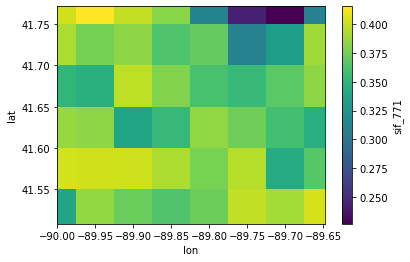

In [66]:
ds = xr.open_dataset(harmonized_f)
ds.sif_771.plot()

# Part 6: Visualizing Harmonized Data

In [46]:
# Data loading
harmonized_path = './data/validation_agb/harmonized'
harmonized_dirs = [os.path.join(harmonized_path, file) for file in os.listdir(harmonized_path) if file.endswith('.nc')]

# Inspect one of the harmonized tiles
sample_data = np.random.choice(harmonized_dirs, 1)
ds = xr.open_dataset(sample_data[0])

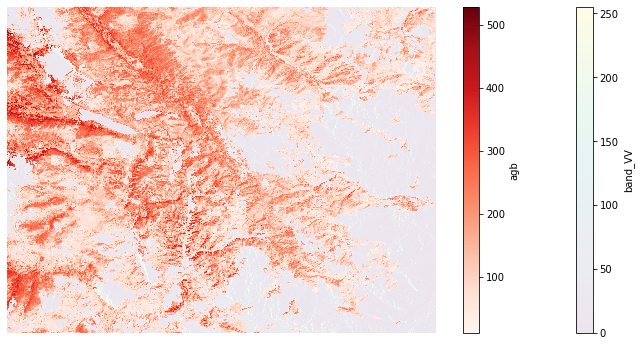

In [47]:
f, ax = plt.subplots(figsize=(12,6))
ds['band_VV'].plot(ax=ax, alpha=0.1)
ds['agb'].plot(ax=ax, cmap='Reds')
ax.set_axis_off()

And that's it! We have successfully combined our dataset together